In [1]:
import numpy as np
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# create a differenced series
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# make a persistence forecast
def persistence(last_ob, n_seq):
    return [last_ob for i in np.arange(n_seq)]
 
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
    forecasts = []
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = persistence(X[-1], n_seq)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = []
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = []
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series['consumption'][index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = test[(n_lag+i)]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# import dataset
series = read_csv('sim_data.csv', header=0, index_col=0, squeeze=True)
    
# configure
n_lag = 1
n_seq = 1
n_test = 2000
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test =  prepare_data(series['consumption'], n_test, n_lag, n_seq)
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)

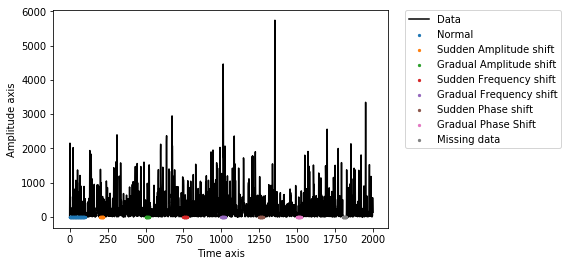

In [2]:
import SimAnomalyDataset as sim
import evaluatePredictions as evalPred
data, anomaly_loc, anomaly_dur, dates = sim.get_data()

# evaluate forecasts
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

actual2=np.reshape(actual,(2000,1))
forecasts2=np.reshape(forecasts,(2000,1))

# Compute comparison metric for predicted vs input (anomalies) [PICK CHANNEL]
out = evalPred.main(actual2[:,0], forecasts2[:,0], metric="MSE")

# Threshold metric before plotting
# thresh = 30
# to_plot = out
# to_plot=np.asarray(to_plot)
# to_plot[to_plot<thresh]=0

sim.plot_data(out, anomaly_loc, anomaly_dur)

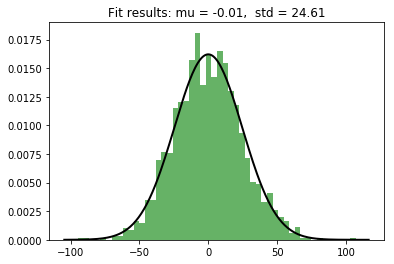

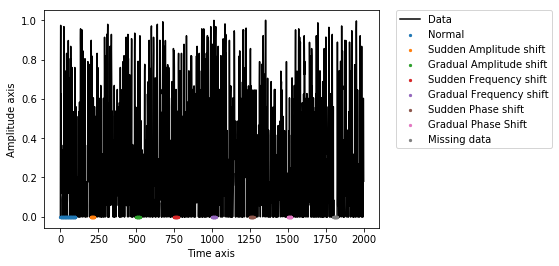

In [3]:
# Fit prediction error with Gaussian to extract anomaly score
pred = actual2[:,0]- forecasts2[:,0]
anomaly_score = evalPred.GaussianPredError(pred, anomaly_loc, anomaly_dur,thresh=0.05)

In [10]:
import numpy as np
import SimAnomalyDataset as sim


# Threshold anomalies to binary
thresh = 0.05
anomaly_score[anomaly_score>thresh]=1
anomaly_score[anomaly_score<thresh]=0

# Get anomaly locations from simulation
data, anomaly_loc, anomaly_dur, dates = sim.get_data(n=0)

# Defined anomaly window size
N_anomalies = np.count_nonzero(anomaly_score)
windowSize = round((len(data)*0.1)/N_anomalies) # 10% of data is window size
windowSize2 = round(windowSize/2)

# Store "unseen" anomalies
anomaly_unseen = anomaly_score
# Initialize empty score array
S=[]
# loop through anomaly locations
for loc in anomaly_loc:
    # define window around anomaly
    window = anomaly_score[loc-(windowSize2):loc+(windowSize2)]
    # loop through anomaly score relative positions
    for y in window: 
        # shift right edge of window to be "zero" position 
        y = y - len(window)
        # apply sigmoid function to relative position
        S.append(sigmoid(window[y]))
    # false negatives and ture positives within window
#     FN_window = window[window==0].sum()
#     TP_window = window[window==1].sum()
    
    # FP are values outside of these window
    anomaly_unseen[loc-(windowSize2):loc+(windowSize2)] = 0
    
# Sum raw scores
A_FP = -.1
S = np.sum(S) + np.sum(anomaly_unseen)*A_FP


# Normalization
Sperfect = 100
Snull = 0 
Snorm = 100*((S-Snull)/(Sperfect-Snull))

Snorm

-150.20000000000002

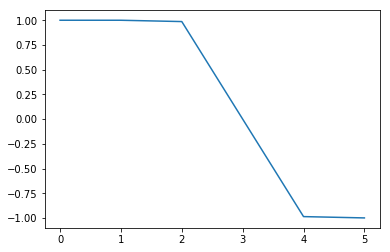

In [5]:
# Sigmoid score function
def sigmoid(y):
    return(2*(1/(1+np.exp(5*y)))-1)

plt.plot(sigmoid(np.arange(-3,3,1)))
plt.show()


In [6]:
# # Get anomaly locations from simulation
# data, anomaly_loc, anomaly_dur, dates = sim.get_data(n="n")

# # Defined anomaly window size
# N_anomalies = 10
# windowSize = (len(data)*0.1)/N_anomalies # 10% of data is window size

# threshold = 20
# anomalies = data
# anomalies[anomalies<data]=0
# # Loop through prediction indicies
# for idx in np.arange(len(data)):
#     if anomalies[idx] > 0 :
#         anomalies[idx-windowSize/2:idx+windowSize/2]

# # Sigmoid score function
# def sigmoid(y, Atp= 1, Afp= -1):
#     return((Atp-Afp)*(1/(1+np.exp(5*y)))-1)

# # Raw score 
# def raw_score(sig,Afn, fd):
#     return np.sum(sig) + Afn*fd

# # Sum raw scores
# S = np.sum(raw_score(sigmoid))

# # Normalization
# Sperfect = 1
# Snull = 0 
# Snorm = 100*((S-Snull)/(Sperfect-Snull))